In [1]:
from tucan.canonicalization import (partition_molecule_by_attribute,
                                    refine_partitions,
                                    assign_canonical_labels,
                                    _add_invariant_code)
from tucan.serialization import serialize_molecule
from tucan.io import graph_from_file
from tucan.graph_utils import permute_molecule
from tucan.visualization import print_molecule, draw_molecules
from pathlib import Path
import networkx as nx

def construct_filepath(name):
    return Path(f"../tests/molfiles/{name}/{name}.mol")

# Canonicalization

A molecule can be represented as a graph with atoms as nodes and bonds as edges.
To identify the nodes they are labeled with integers.
When two chemists draw the same molecule, they'll probably label the nodes differently (by drawing the nodes in different orders for instance), as illustrated with the example of water in `Figure 1`.

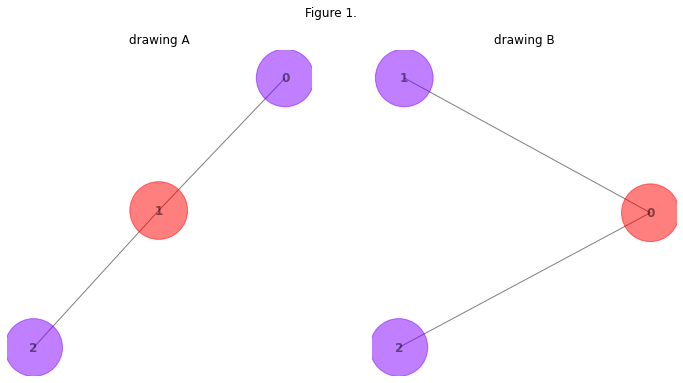

In [2]:
m = graph_from_file(construct_filepath("water"))
m_permuted = permute_molecule(m, random_seed=.42)
draw_molecules([m, m_permuted], ["drawing A", "drawing B"], highlight="atomic_number", title="Figure 1.")

If both molecules were saved in a database, we'd end up with duplicate molecules,
since the chemical structures are equivalent and merely differ in the labels (i.e, they are isomorphic).
How do we know that the chemists are submitting the same molecule to the database?
This problem can be solved with canonicalization, that is, by assigning unique (canonical) node labels such that any two molecules that are isomorphic receive the same labeling.
According to [Reed & Corneil (1977)](https://sci-hub.ru/https://doi.org/10.1002/jgt.3190010410), "[t]wo [molecules M]1 and [M]2 are isomorphic if there exists a one-to-one mapping of the [nodes] of [M]1 onto the [nodes] of [M]2 such that adjacency is preserved,
i.e. two [nodes] in [M]1 are adjacent if and only if the corresponding [nodes] of [M]2 are adjacent."
However, the process of finding a canonical labeling can be computationally expensive as we'll show in the following.

A graph-labeling can be conceptualized as a string.
For example, we could order the node labels in `Figure 1, drawing A` by atomic number (first the purple hydrogen atoms, then the red oxygen atom) and string them together, resulting in the labeling `021`.
A _canonical_ labeling can be conceptualized as the [lexicographically](https://en.wikipedia.org/wiki/Lexicographic_order) minimal or maximal form of that string (let's use the minimal form for our example).
We can determine the canonical labeling by enumerating all possible strings that can be constructed from the three nodes, and choosing the minimal string (in this case, the first string).

| | hydrogen A | hydrogen B | oxygen |
|--|---|---|---|
|1.|0|1|2|
|2.|0|2|1|
|3.|1|0|2|
|4.|1|2|0|
|5.|2|0|1|
|6.|2|1|0|

The number of possible strings is $1*2*3=3!$, $N!$ in the general case. As $N$ grows larger, the number of labelings we need to enumerate with this brute-force approach grows rapidly. For a  modestly-sized molecule with ten nodes we need to enumerate $10!=3,628,800$ labelings.
Luckily, the computational costs of generating all $N!$ permutations of the node labels can be reduced by using invariants to partition the nodes into subsets.

## Molecule partitioning based on node-invariants
In the following, we use the term _invariant_ in the sense of _node-invariant_ (pertaining to a single node) as opposed to _graph-invariant_ (pertaining to the entire graph).
Invariants are node-properties that are independent of the labeling.
For instance, in `Figure 1`, the red oxygen atom, irrespective of its label, will always have the atomic number 8, and will always be connected to two hydrogens.

We can use the atomic numbers to partition the water molecule into two subsets, one subset containing the two hydrogens (atomic number 1), and another subset containing the oxygen (atomic number 8).
As mentioned earlier, in our example we chose to sort the nodes by atomic number in order to obtain the canonical labeling.
Therefore, we already know in advance that the oxygen atom receives the label `2`.
All that's left to permute are the labels of the two hydrogens.

| | hydrogen A | hydrogen B | oxygen |
|--|---|---|---|
|1.|0|1|2|
|2.|1|0|2|

By partitioning the nodes into $k$ subsets containing $n_k$ nodes, we reduce $N!$ permutations to $\prod_{i=1}^{k}n_i!$.

The nodes in a partition are equivalent w.r.t. to the invariants.
Note that this does not imply that nodes within the same partition are automorphic ([Ivanciuc, 2008](https://sci-hub.ru/10.1002/9783527618279.ch7a)).
Equivalence w.r.t. the invariants is necessary but not sufficient for automorphism.
An automorphism group (aka orbit) is a set of nodes that have a structurally equivalent position in the graph, in other words, the nodes are symmetry-equivalent.
For example, the two automorphism groups in the table above are the two hydrogens $\{0, 1\}$, and the oxygen $\{2\}$.
The nodes within those groups are structurally interchangeable.

In order to make the canonicalization computationally as cheap as possible, we aim to partition the molecule such that each partition contains as few nodes as possible. To achieve this, we need invariants with strong discriminatory power. In the remainder of the notebook, we introduce our invariants and show how they partition the nodes of an exemplary molecule, before we eventually assign canonical labels to the partitioned nodes.

### Atomic number
The atomic number is a straightforward invariant that doesn't require additional computation.
However, in cases of pure substances such as sulfur, the atomic number has no discriminatory power: all nodes are allocated to the same partition.
In general, based on atomic number, we can obtain at most as many partitions as there are different elements in a chemical structure.
The atomic numbers partition our example-molecule into three subsets (partition `0` through `2`), as is evident from `Table 1` and `Figure 2` below.

Table 1. Bicyclo[5.1.0]octa-1(7)-ene-8-one partitioned by atomic number.
label    invariants    partition    neighbors (label, invariants, partition)
-------  ------------  -----------  ----------------------------------------------------
0        001           0            (13, 006, 1)
1        001           0            (11, 006, 1)
2        001           0            (10, 006, 1)
3        001           0            (11, 006, 1)
4        001           0            (14, 006, 1)
5        001           0            (14, 006, 1)
6        001           0            (12, 006, 1)
7        001           0            (13, 006, 1)
8        001           0            (10, 006, 1)
9        001           0            (12, 006, 1)
10       006           1            (15, 006, 1), (14, 006, 1), (2, 001, 0), (8, 001, 0)
11       006           1            (14, 006, 1), (13, 006, 1), (1, 001, 0), (3, 001, 0)
12       006           1            (13, 006, 1), (16, 006, 1), (6, 001, 0), (9, 001, 0)
13  

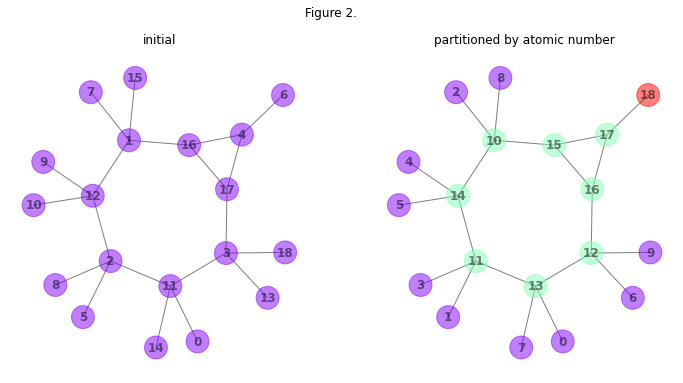

In [3]:
molecule = "Bicyclo[5.1.0]octa-1(7)-ene-8-one"
m = permute_molecule(graph_from_file(construct_filepath(molecule)), random_seed=.41)
_add_invariant_code(m)
m_partitioned_by_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=False)
print_molecule(m_partitioned_by_invariants, f"Table 1. {molecule.capitalize()} partitioned by atomic number.")
draw_molecules([m, m_partitioned_by_invariants], ["initial", "partitioned by atomic number"], highlight="partition", title="Figure 2.")

### Multiset of neighboring atomic numbers
We can increase the discriminatory power of the atomic number invariant by incorporating information about the direct neighbors of a node $i$, that is, all neighboring nodes that are connected to $i$ by a single edge.
For example, nodes `16` and `17` from partition `1` are each connected to three direct neighbors.

| label | invariants | partition | neighbors (label, invariants, partition) |
|---|---|---|---|
|16   |    6         |        1        |    (12, 6, 1), (17, 6, 1), (15, 6, 1)|
|17   |    6          |       1        |    (18, 8, 2), (16, 6, 1), (15, 6, 1)|

However, nodes `16` and `17` are connected to different multisets of their neighbors' atomic numbers. Node `16` is connected to three carbons, whereas node `17` is connected to two carbons and one oxygen.
Similarly, we can discriminate nodes if they belong to the same partition but have a different _number_ of direct neighbors.
That is, with the _multiset_ of a node's direct neighbors' atomic numbers we essentially add two more invariants: the number of direct neighbors as well as the _configuration_ of neighbors. As can be seen below in `Table 2` and `Figure 3`, if we partition the molecule with this updated invariant, we end up with a total of five partitions, two more compared to the partitioning by local invariants.

Table 2. Bicyclo[5.1.0]octa-1(7)-ene-8-one partitioned by multiset of neighboring atomic numbers.
label    invariants    partition    neighbors (label, invariants, partition)
-------  ------------  -----------  ----------------------------------------------------
0        001           0            (13, 006, 1)
1        001           0            (11, 006, 1)
2        001           0            (10, 006, 1)
3        001           0            (11, 006, 1)
4        001           0            (14, 006, 1)
5        001           0            (14, 006, 1)
6        001           0            (12, 006, 1)
7        001           0            (13, 006, 1)
8        001           0            (10, 006, 1)
9        001           0            (12, 006, 1)
10       006           1            (15, 006, 2), (14, 006, 1), (2, 001, 0), (8, 001, 0)
11       006           1            (14, 006, 1), (13, 006, 1), (1, 001, 0), (3, 001, 0)
12       006           1            (16, 006, 2), (13, 006, 1), (6, 

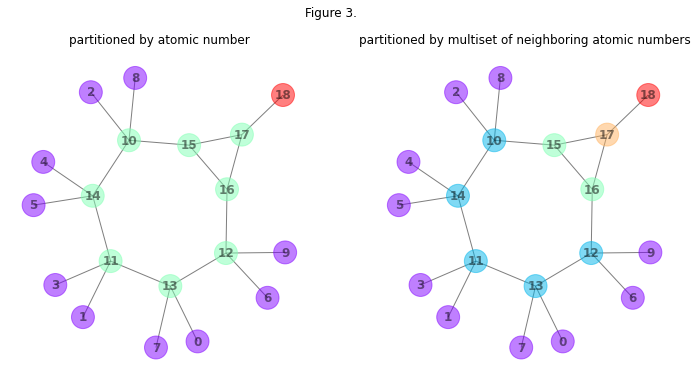

In [4]:
m_partitioned_by_extended_invariants = partition_molecule_by_attribute(m, "invariant_code", include_neighbors=True)
print_molecule(m_partitioned_by_extended_invariants, f"Table 2. {molecule.capitalize()} partitioned by multiset of neighboring atomic numbers.")
draw_molecules([m_partitioned_by_invariants, m_partitioned_by_extended_invariants],
               ["partitioned by atomic number", "partitioned by multiset of neighboring atomic numbers"],
               highlight="partition", title="Figure 3.")

## Partition refinement (Weisfeiler-Leman)
Once we've partitioned the molecule based on the invariants, we can try to refine the partitions.
That is, we can try to further split the partitions finding nodes that can be discriminated.

When we have a look at nodes `10` through `14` from partition `1` in `Table 2`, we notice that $\{10, 12\}$ are connected to a different multiset of partitions than $\{11, 13, 14\}$. Specifically nodes $\{10, 12\}$ are connected to the partition-multiset $\{2, 1, 0, 0\}$, whereas $\{11, 13, 14\}$ are connected to partitions $\{1, 1, 0, 0\}$.

| label | invariants | partition | neighbors (label, invariants, partition) |
|---|---|---|---|
|10   |    6  |               1   |         (15, 6, 2), (14, 6, 1), (2, 1, 0), (8, 1, 0)|
|11   |    6   |              1    |        (14, 6, 1), (13, 6, 1), (1, 1, 0), (3, 1, 0)|
|12    |   6    |             1     |       (16, 6, 2), (13, 6, 1), (6, 1, 0), (9, 1, 0)|
|13     |  6     |            1      |      (11, 6, 1), (12, 6, 1), (0, 1, 0), (7, 1, 0)|
|14      | 6      |           1       |     (10, 6, 1), (11, 6, 1), (4, 1, 0), (5, 1, 0)|

This means that we can further discriminate the nodes in partition `1` based on the their neighbors' multisets of partitions.
In other words, we can refine the partitions recursively ("partitioning by partition").
In `Figure 4` we show what happens if we repeat the recursive partitioning until the number of partitions doesn't change anymore:
throughout three rounds of refinement, we go from six to eight to eventually nine partitions.
Recursive partitioning is conceptually related to _color-refinement_ in the sense of the _Weisfeiler-Leman_ algorithm ([Kiefer, 2020](https://sci-hub.ru/https://doi.org/10.1145/3436980.3436982); [Bieber, 2019](https://www.davidbieber.com/post/2019-05-10-weisfeiler-lehman-isomorphism-test/)), which is known in chemistry as the _Morgan_ algorithm ([Morgan, 1965](https://sci-hub.ru/https://doi.org/10.1021/c160017a018)).


refinement iteration 1
label    invariants    partition    neighbors (label, invariants, partition)
-------  ------------  -----------  ----------------------------------------------------
0        001           0            (11, 006, 1)
1        001           0            (10, 006, 1)
2        001           0            (13, 006, 2)
3        001           0            (10, 006, 1)
4        001           0            (12, 006, 1)
5        001           0            (12, 006, 1)
6        001           0            (14, 006, 2)
7        001           0            (11, 006, 1)
8        001           0            (13, 006, 2)
9        001           0            (14, 006, 2)
10       006           1            (12, 006, 1), (11, 006, 1), (1, 001, 0), (3, 001, 0)
11       006           1            (14, 006, 2), (10, 006, 1), (0, 001, 0), (7, 001, 0)
12       006           1            (13, 006, 2), (10, 006, 1), (4, 001, 0), (5, 001, 0)
13       006           2            (15, 006, 3), (12,

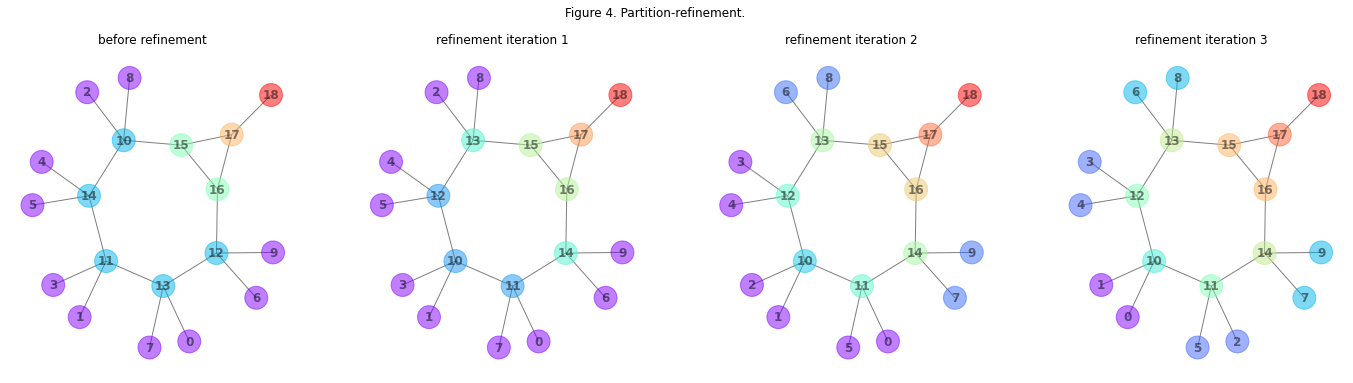

In [5]:
refinements = list(refine_partitions(m_partitioned_by_extended_invariants))
draw_molecules([m_partitioned_by_extended_invariants] + refinements,
               ["before refinement"] + [f"refinement iteration {i + 1}" for i in range(len(refinements))],
               highlight="partition", title="Figure 4. Partition-refinement.")
for i, m_partitioned in enumerate(refinements):
    print_molecule(m_partitioned, f"refinement iteration {i + 1}")

After the refinement, no partition contains more than two nodes.
This brings us closer to the goal of the canonicalization, that is, we are closer to shattering the molecule such that each node resides in a unique partition.
To distinguish the nodes within the partitions, that is, to assign unique labels to each node, we use the "bliss" canonicalization algorithm ([https://doi.org/10.1137/1.9781611972870.13](https://sci-hub.st/https://doi.org/10.1137/1.9781611972870.13)).

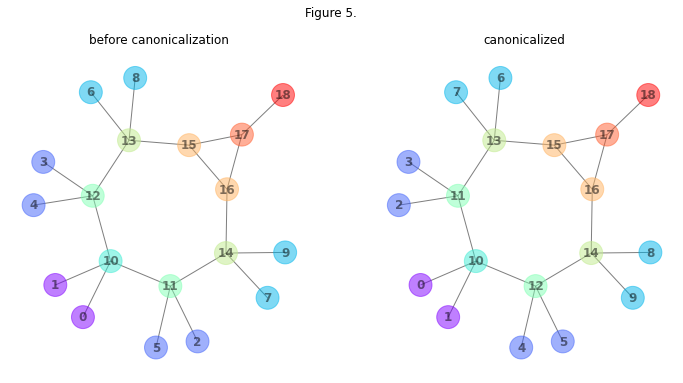

In [6]:
canonical_idcs = assign_canonical_labels(m_partitioned)
m_canonicalized = nx.relabel_nodes(m_partitioned, canonical_idcs, copy=True)
draw_molecules([m_partitioned, m_canonicalized], ["before canonicalization", "canonicalized"],
               highlight="partition", title="Figure 5.")

# Serialization
The serialization represents a molecule as a string that should allow both humans and machines to reconstruct the molecule's topology (i.e., the molecular graph). Our string representation consists of the sum formula (arranged according to the [Hill system](https://en.wikipedia.org/wiki/Chemical_formula#Hill_system)), followed by a sequence of 2-tuples. Each tuple represents the labels of two connected nodes.

In [7]:
print(serialize_molecule(m_canonicalized))

C8H10O/1-11/2-11/3-12/4-12/5-13/6-13/7-14/8-14/9-15/10-15/11-12/11-13/12-14/13-15/14-16/15-17/16-17/16-18/17-18/18-19


In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing node labels pertain to nodes with increasing atomic number. This means that we can infer the atomic number associated with a node label from the sum formula. For example, the sum formula above indicates that the molecule consists of ten hydrogens, eight carbons, and one oxygen. Since increasing labels pertain to nodes with increasing atomic numbers, we can infer that the labels `1` through `10` pertain to hydrogens, whereas labels `11` through `18` refer to carbons, and finally, label `19` refers to the oxygen.